In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing
import gc

In [2]:
files = ['ieee-fraud-detection/test_identity.csv', 
         'ieee-fraud-detection/test_transaction.csv',
         'ieee-fraud-detection/train_identity.csv',
         'ieee-fraud-detection/train_transaction.csv',
         'ieee-fraud-detection/sample_submission.csv']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

In [3]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

test.columns = test.columns.str.replace('-','_')

del test_id, test_tr, train_id, train_tr
gc.collect()

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
for col in tqdm_notebook(train.columns): 
    if (train[col].dtype == 'object') :
        le = LabelEncoder() 
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values)) 
        train[col] = le.transform(list(train[col].astype(str).values))

In [ ]:
train.info(verbose=True)

In [10]:
del test
gc.collect()

75

In [11]:
train = reduce_mem_usage(train)


Mem. usage decreased to 426.33 Mb (73.2% reduction)


In [12]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

del train
gc.collect()

34

In [13]:
X.fillna(-999, inplace=True)

In [14]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [17]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=3, shuffle=False), scoring='roc_auc', verbose=2)

In [18]:
%%time
rfe.fit(X, y)

Fitting estimator with 349 features.
Fitting estimator with 339 features.
Fitting estimator with 329 features.
Fitting estimator with 319 features.
Fitting estimator with 309 features.
Fitting estimator with 299 features.
Fitting estimator with 289 features.
Fitting estimator with 279 features.
Fitting estimator with 269 features.
Fitting estimator with 259 features.
Fitting estimator with 249 features.
Fitting estimator with 239 features.
Fitting estimator with 229 features.
Fitting estimator with 219 features.
Fitting estimator with 209 features.
Fitting estimator with 199 features.
Fitting estimator with 189 features.
Fitting estimator with 179 features.
Fitting estimator with 169 features.
Fitting estimator with 159 features.
Fitting estimator with 149 features.
Fitting estimator with 139 features.
Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.
Fitting estimator with 99 features.
Fitting estimator with 89 features.
Fit

RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_we....03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=-1, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsam

In [19]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 139


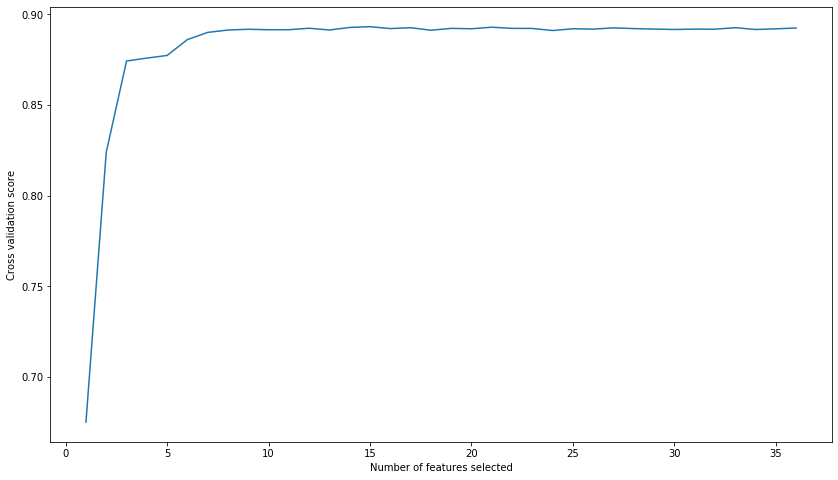

In [20]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [21]:
for col in X.columns[rfe.ranking_ == 1]:
    print(col)

TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
dist1
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D8
D9
D10
D11
D12
D14
D15
M2
M3
M4
M5
M6
M8
M9
V5
V12
V13
V19
V20
V35
V36
V37
V38
V44
V45
V53
V54
V56
V61
V62
V70
V74
V75
V76
V78
V82
V83
V87
V91
V96
V99
V126
V127
V128
V130
V131
V139
V143
V160
V165
V170
V171
V187
V201
V203
V207
V208
V210
V213
V215
V217
V222
V251
V258
V261
V264
V265
V266
V267
V268
V274
V277
V279
V280
V282
V283
V285
V287
V289
V291
V294
V306
V307
V308
V310
V312
V313
V314
V315
V317
V323
V324
V332
id_01
id_02
id_05
id_06
id_13
id_14
id_17
id_19
id_20
id_30
id_31
id_33
id_38
DeviceType
DeviceInfo
